In [1]:
import json
import os
import pandas as pd
import nltk
import gensim as gs
import pickle
import pyLDAvis.gensim
nltk.download('punkt')
dataset_folder = "yelp_dataset_challenge_academic_dataset"
business_datafile = "yelp_academic_dataset_business.json"
review_datafile = "yelp_academic_dataset_review.json"
user_datafile = "yelp_academic_dataset_user.json"

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\prady\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Reading the data about businesses
The _yelp_academic_dataset_business_ file contains data about businesses like their address,operating hours and many other attributes. We are currently interested in the data about restaurants.

In [203]:
business_data = pd.read_json(f"../{dataset_folder}/{business_datafile}", lines=True, typ="frame", orient="columns")
business_data.drop(["hours", "open", "full_address", "neighborhoods", "longitude", "latitude", "attributes", "type", "review_count"], axis=1, inplace=True)
business_data.set_index("business_id", inplace=True, verify_integrity=True)

Since the above dataset contains businesses which are not restaurants we are going to filter the restaurants from that list. For that we are going to check the _categories_ column to see if it has the tag **Restaurants** in it. If it does then it's a restaurant

In [204]:
restaurant_data = business_data[business_data["categories"].apply(lambda x: "Restaurants" in x)]
restaurant_data

,categories,city,review_count,name,state,stars
business_id,,,,,,
JwUE5GmEO-sH1FuwJgKBlQ,[Restaurants],De Forest,26,Pine Cone Restaurant,WI,4.0
uGykseHzyS5xAMWoN6YUqA,"[American (Traditional), Restaurants]",De Forest,16,Deforest Family Restaurant,WI,4.0
LRKJF43s9-3jG9Lgx4zODg,"[Food, Ice Cream & Frozen Yogurt, Fast Food, R...",De Forest,7,Culver's,WI,4.5
RgDg-k9S5YD_BaxMckifkg,"[Chinese, Restaurants]",De Forest,3,Chang Jiang Chinese Kitchen,WI,4.0
rdAdANPNOcvUtoFgcaY9KA,"[American (Traditional), Restaurants]",Mc Farland,33,Green Lantern Restaurant,WI,3.5
...,...,...,...,...,...,...
ZpB2O-WAbbRHdP0V8GrwXA,"[American (New), Restaurants]",Henderson,34,LYFE Kitchen,NV,3.5
OEUIE8VBa1BbBfr5EPcTOA,"[Food, Juice Bars & Smoothies, American (New),...",Henderson,27,Presto Cafe,NV,4.5
yZXEELxi8KMwzXCHP345GQ,"[Bars, Turkish, Mediterranean, Nightlife, Loun...",Las Vegas,18,Maza Mediterranean Grill & Lounge,NV,4.5


### Reading the reviews
The _yelp_academic_dataset_review.json_ file contains reviews of all the businesses. We will extract that data into a table and remove some unwanted attributes and rows that don't contain a review.

In [206]:
business_review = pd.read_json(f"../{dataset_folder}/{review_datafile}", typ="frame", orient="columns", lines=True)
business_review.drop(["votes", "type", "review_id"], axis=1, inplace=True)
business_review.rename(columns={"text": "review"}, inplace=True)

business_review

,user_id,stars,date,review,business_id
0,Xqd0DzHaiyRqVH3WRG7hzg,5,2007-05-17,dr. goldberg offers everything i look for in a...,vcNAWiLM4dR7D2nwwJ7nCA
1,H1kH6QZV7Le4zqTRNxoZow,2,2010-03-22,"Unfortunately, the frustration of being Dr. Go...",vcNAWiLM4dR7D2nwwJ7nCA
2,zvJCcrpm2yOZrxKffwGQLA,4,2012-02-14,Dr. Goldberg has been my doctor for years and ...,vcNAWiLM4dR7D2nwwJ7nCA
3,KBLW4wJA_fwoWmMhiHRVOA,4,2012-03-02,Been going to Dr. Goldberg for over 10 years. ...,vcNAWiLM4dR7D2nwwJ7nCA
4,zvJCcrpm2yOZrxKffwGQLA,4,2012-05-15,Got a letter in the mail last week that said D...,vcNAWiLM4dR7D2nwwJ7nCA
...,...,...,...,...,...
1125453,lhMo-dGq0V2iKqBIiwUJSg,5,2010-08-11,"Located at the bottom of Lauriston Place, this...",BVxlrYWgmi-8TPGMe6CTpg
1125454,TTrzXCtB2MZA8Azw56bRlw,5,2012-06-15,I love this place! I think the staff struggle ...,BVxlrYWgmi-8TPGMe6CTpg
1125455,rtS7mDof5d-cEPBsmVuUJw,3,2013-09-17,Perfect little shop to go to if you want to pi...,BVxlrYWgmi-8TPGMe6CTpg
1125456,tZs84cKAUSOtP_nAiSdreQ,4,2013-09-18,I visit here once or twice a month. Just to ge...,BVxlrYWgmi-8TPGMe6CTpg


As before, the _business_review_ table contains reviews of all businesses in the data but we are only interested in the reviews of the restaurants we have extracted in our _restaurant_data_ table. Hence we are going to inner join the two tables on the business_id column so that we are only left with our list of restaurants and their reviews

In [207]:
restaurant_review = business_review.join(restaurant_data, on="business_id", how="inner", lsuffix="_review", rsuffix="_restaurant")
restaurant_review

,user_id,stars_review,date,review,business_id,categories,city,review_count,name,state,stars_restaurant
8,zvNimI98mrmhgNOOrzOiGg,4,2008-07-07,Pretty good dinner with a nice selection of fo...,JwUE5GmEO-sH1FuwJgKBlQ,[Restaurants],De Forest,26,Pine Cone Restaurant,WI,4.0
9,p4ySEi8PEli0auZGBsy6gA,4,2009-05-03,Good truck stop dining at the right price. We ...,JwUE5GmEO-sH1FuwJgKBlQ,[Restaurants],De Forest,26,Pine Cone Restaurant,WI,4.0
10,ZYaumz29bl9qHpu-KVtMGA,4,2009-05-04,"If you like lot lizards, you'll love the Pine ...",JwUE5GmEO-sH1FuwJgKBlQ,[Restaurants],De Forest,26,Pine Cone Restaurant,WI,4.0
11,SvS7NXWG2B2kFoaHaWdGfg,4,2010-10-30,Enjoyable experience for the whole family. The...,JwUE5GmEO-sH1FuwJgKBlQ,[Restaurants],De Forest,26,Pine Cone Restaurant,WI,4.0
12,qOYI9O0ecMJ9VaqcM9phNw,4,2011-02-06,One of my favorite truck stop diners with soli...,JwUE5GmEO-sH1FuwJgKBlQ,[Restaurants],De Forest,26,Pine Cone Restaurant,WI,4.0
...,...,...,...,...,...,...,...,...,...,...,...
1125433,1fgKqvcZbFpY7sbgCxxyvA,5,2014-07-14,Ive never had bad pizza or pasta here. Very a...,uUsfpN81JCMKyH6c0D0bTg,"[Food, Desserts, Italian, Pizza, Restaurants]",Las Vegas,6,Rocco's NY Pizza & Pasta,NV,4.0
1125434,11QzsQ-nmRykVvD4agGRPw,4,2014-07-14,3.5 stars.\n\nTried this place for dinner and ...,uUsfpN81JCMKyH6c0D0bTg,"[Food, Desserts, Italian, Pizza, Restaurants]",Las Vegas,6,Rocco's NY Pizza & Pasta,NV,4.0
1125450,AnH84g9V10x41CXmCvcaFg,5,2014-07-10,My new favorite restaurant. They have 22 diff...,BMjggIgOghBMEXPo8q7q3w,"[Kosher, Italian, Pizza, Restaurants]",Phoenix,5,LaBella Pizzeria and Restaurant,AZ,5.0
1125451,pslJujFe9XO28lMm8izNtg,5,2014-07-16,GreAt food awesome service . The best fish in ...,BMjggIgOghBMEXPo8q7q3w,"[Kosher, Italian, Pizza, Restaurants]",Phoenix,5,LaBella Pizzeria and Restaurant,AZ,5.0


The _stars_review_ refers to the star rating given as part of the review whereas the _stars_restaurant_ refers to the average rating of that restaurant

Some of the reviews may have empty text so we are going to remove those

In [208]:
restaurant_review = restaurant_review[restaurant_review["review"].isnull().values == False]

### Preprocessing

#### Tokenising
In this step we are converting the plain text reviews in our data into an array of words. This is needed for the next step where we create a bag of words representation of our reviews. Additionally, we have also converted all of the words into lowercase in order to avoid the same word being treated as a different token in our bag of words model due to different casing.

_Note: This step can take a significant amount of time_

In [209]:
def tokenise(sentence):
    words = nltk.word_tokenize(sentence)
    words = [x.lower() for x in words]
    return words

restaurant_review["review"] = restaurant_review["review"].apply(tokenise)
restaurant_review

,user_id,stars_review,date,review,business_id,categories,city,review_count,name,state,stars_restaurant
8,zvNimI98mrmhgNOOrzOiGg,4,2008-07-07,"[pretty, good, dinner, with, a, nice, selectio...",JwUE5GmEO-sH1FuwJgKBlQ,[Restaurants],De Forest,26,Pine Cone Restaurant,WI,4.0
9,p4ySEi8PEli0auZGBsy6gA,4,2009-05-03,"[good, truck, stop, dining, at, the, right, pr...",JwUE5GmEO-sH1FuwJgKBlQ,[Restaurants],De Forest,26,Pine Cone Restaurant,WI,4.0
10,ZYaumz29bl9qHpu-KVtMGA,4,2009-05-04,"[if, you, like, lot, lizards, ,, you, 'll, lov...",JwUE5GmEO-sH1FuwJgKBlQ,[Restaurants],De Forest,26,Pine Cone Restaurant,WI,4.0
11,SvS7NXWG2B2kFoaHaWdGfg,4,2010-10-30,"[enjoyable, experience, for, the, whole, famil...",JwUE5GmEO-sH1FuwJgKBlQ,[Restaurants],De Forest,26,Pine Cone Restaurant,WI,4.0
12,qOYI9O0ecMJ9VaqcM9phNw,4,2011-02-06,"[one, of, my, favorite, truck, stop, diners, w...",JwUE5GmEO-sH1FuwJgKBlQ,[Restaurants],De Forest,26,Pine Cone Restaurant,WI,4.0
...,...,...,...,...,...,...,...,...,...,...,...
1125433,1fgKqvcZbFpY7sbgCxxyvA,5,2014-07-14,"[ive, never, had, bad, pizza, or, pasta, here,...",uUsfpN81JCMKyH6c0D0bTg,"[Food, Desserts, Italian, Pizza, Restaurants]",Las Vegas,6,Rocco's NY Pizza & Pasta,NV,4.0
1125434,11QzsQ-nmRykVvD4agGRPw,4,2014-07-14,"[3.5, stars, ., tried, this, place, for, dinne...",uUsfpN81JCMKyH6c0D0bTg,"[Food, Desserts, Italian, Pizza, Restaurants]",Las Vegas,6,Rocco's NY Pizza & Pasta,NV,4.0
1125450,AnH84g9V10x41CXmCvcaFg,5,2014-07-10,"[my, new, favorite, restaurant, ., they, have,...",BMjggIgOghBMEXPo8q7q3w,"[Kosher, Italian, Pizza, Restaurants]",Phoenix,5,LaBella Pizzeria and Restaurant,AZ,5.0
1125451,pslJujFe9XO28lMm8izNtg,5,2014-07-16,"[great, food, awesome, service, ., the, best, ...",BMjggIgOghBMEXPo8q7q3w,"[Kosher, Italian, Pizza, Restaurants]",Phoenix,5,LaBella Pizzeria and Restaurant,AZ,5.0


#### Stop Word Removal
Since all of the reviews in this corpus are for restaurants there will be certain words that are common in this domain. For example, words like food and restaurant is expected to appear very frequently in the reviews and although they are not standard stop words for english they don't add any semantic meaning to the task at hand. Hence, we'll have to build a custom list of stop words tailored for restaurant reviews.

1. **Build our vocabulary and word counts so we know the frequent words in the corpus**
    We then remove those words from the reviews

In [211]:
id2word = gs.corpora.Dictionary(restaurant_review["review"])
word_counts = pd.Series({id2word[tid]: count for tid, count in id2word.cfs.items()})

word_counts = word_counts.sort_values(ascending=False)
word_counts.head(30)

2. **Create our custom stop words list**
    
    We have got a list of standard english stop words from https://www.ranks.nl/stopwords and have saved them in the file stopwords.txt. Moreover, frequent words like food, place, get, etc do not contribute much semantic meaning. We'll add them to our list of stop words.

In [ ]:
default_stop_words = set()
with open('stopwords.txt', 'r') as f:
    default_stop_words = set([w.strip() for w in f.readlines()])
custom_stop_words = default_stop_words.union(set(word_counts.index[:30]))

We then remove all of our stop words from the reviews and words that are less than 4 characters.

In [214]:
restaurant_review["review"] = restaurant_review["review"].apply(lambda review: [word for word in review if word not in custom_stop_words and len(word) >= 4])

In [221]:
#Writing this out to a file so that we don't have to preprocess everytime
restaurant_review.to_csv("restaurant_reviews_processed.csv", encoding="utf-8", sep=":")

In [2]:
#restaurant_review = pd.read_csv("restaurant_reviews_processed.csv", sep=":", converters={'review': eval})

### Topic Modelling
1. Topics by state
2. Topics by review rating
3. Topics by popular users

In [3]:
def create_lda_model(reviews, topic_count):
    dictionary = gs.corpora.Dictionary(reviews)
    corpus = [dictionary.doc2bow(text) for text in reviews]
    ldamodel = gs.models.ldamodel.LdaModel(corpus, num_topics = topic_count, id2word=dictionary, passes=10, alpha="auto")
    return (ldamodel, corpus, dictionary)

In [4]:
def output_model_results_as_csv(filename, model, num_of_words):
    topics = model.print_topics(num_words=num_of_words)
    with open(filename, "w") as f:
        for topic in topics:
            for items in topic[1].split("+"):
                t = items.split("*")
                weight = int(float(t[0]) * 1000)
                f.write(f"{t[1].strip()[1:-1]},{weight},{topic[0]}\n")

#### Topics by states

We are first going to create 3 topic models per state to see the patterns of things people discuss across states. We are only considering state that have more than 50 reviews because the topics are not very meaningful and all 3 of them tend to be similar of there are too few reviews.

In [5]:
reviews_by_state = restaurant_review.groupby("state")

states_counts_map = {st: len(idxs) for st, idxs in reviews_by_state.indices.items() if len(idxs) > 50}
states_counts_map

{'AZ': 324468, 'EDH': 9902, 'MLN': 350, 'NV': 344321, 'ON': 1747, 'WI': 25824}

As you can see the states have a really high number of rows. Model creation takes significantly longer on such large data so we have sampled a maximum of 10000 rows from each state. If the state has < 10k rows then we train on all of them.

In [7]:
state_wise_models = {}
for state, row_cnt in states_counts_map.items():
    os.makedirs(f"models/{state}")
    
    if row_cnt > 10000:
        training_set = reviews_by_state.get_group(state).sample(10000)
    else:
        training_set = reviews_by_state.get_group(state)
    
    (ldamodel, corpus, dictionary) = create_lda_model(training_set["review"], 3)
    ldamodel.save(f"./models/{state}/model.gensim")
    dictionary.save(f"./models/{state}/dict.gensim")
    with open(f"./models/{state}/corpus.pkl", "wb") as c:
        pickle.dump(corpus, c)
    state_wise_models[state] = ldamodel

In [13]:
def create_pyLdaVis(state):
    c_az = pickle.load(open(f"./models/{state}/corpus.pkl", "rb"))
    d_az = gs.corpora.Dictionary.load(f"./models/{state}/dict.gensim")
    m_az = state_wise_models[state]
    lda_display = pyLDAvis.gensim.prepare(m_az, c_az, d_az, sort_topics=False)
    with open(f"./models/{state}/display.html", "w", encoding="utf-8") as f:
        pyLDAvis.save_html(lda_display, f)
    return lda_display

In [14]:
state_vis_map = {}
for state in states_counts_map.keys():
    d = create_pyLdaVis(state)
    state_vis_map[state] = d

C:\Users\prady\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))
C:\Users\prady\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))
C:\Users\prady\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future be

##### AZ
Mexican and thai cuisines seem to dominate in Arizona although the two most popular dishes seem to be sushi and pizza. The topic in green looks like its about fast food which also seems like a prominent topic.
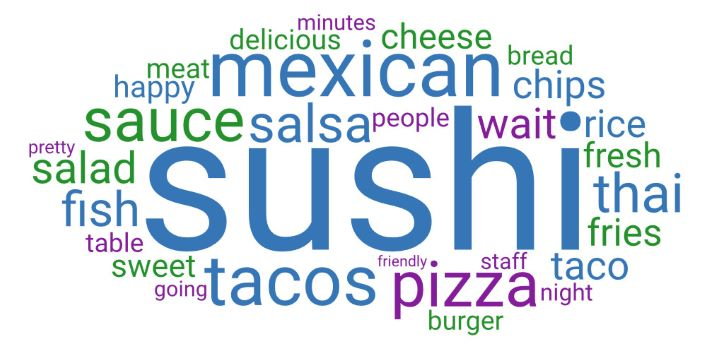

#### Topics by review rating
Topics with rating >= 4 are considered positive and rating < 4 are considered negative

In [15]:
positive_reviews = restaurant_review[restaurant_review["stars_review"] >= 4]
negative_reviews = restaurant_review[restaurant_review["stars_review"] < 4]

print(f"Number of positive reviews: {positive_reviews.shape[0]}")
print(f"Number of negative reviews: {negative_reviews.shape[0]}")

Number of positive reviews: 464699
Number of negative reviews: 241947


Sampling 20k records each from positive and negative reviews and creating the topic models. We will be fetching 5 topics for each category since the categories are broader

In [16]:
positive_training_set = positive_reviews["review"].sample(20000)
(positive_model, corpus_pos, dict_pos) = create_lda_model(positive_training_set, 5)

In [17]:
negative_training_set = negative_reviews["review"].sample(20000)
(negative_model, corpus_neg, dict_neg) = create_lda_model(negative_training_set, 5)

Writing the models to files

In [19]:
os.makedirs("models/ratings")
positive_model.save("./models/ratings/positive.gensim")
negative_model.save("./models/ratings/negative.gensim")

dict_pos.save("./models/ratings/dict_positive.gensim")
dict_neg.save("./models/ratings/dict_negative.gensim")

with open("./models/ratings/corpus_pos.pkl", "wb") as c:
    pickle.dump(corpus_pos, c)
with open("./models/ratings/corpus_neg.pkl", "wb") as g:
    pickle.dump(corpus_neg, g)

Creating and saving the pyLDAvis visualisations as HTML files

In [20]:
pos_lda_vis = pyLDAvis.gensim.prepare(positive_model, corpus_pos, dict_pos, sort_topics=False)
with open("models/ratings/disp_pos.html", "w", encoding="utf-8") as p:
    pyLDAvis.save_html(pos_lda_vis, p)
    
neg_lda_vis = pyLDAvis.gensim.prepare(negative_model, corpus_neg, dict_neg, sort_topics=False)
with open("models/ratings/disp_neg.html", "w", encoding="utf-8") as n:
    pyLDAvis.save_html(neg_lda_vis, n)

C:\Users\prady\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))
C:\Users\prady\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [267]:
output_model_results_as_csv("positive.csv", positive_model, 10)
output_model_results_as_csv("negative.csv", negative_model, 10)

#### Topics by popular users

In [22]:
users = pd.read_json(f"../{dataset_folder}/{user_datafile}", lines=True, typ="frame", orient="columns")
users.drop(["yelping_since", "votes", "friends", "type", "compliments", "elite"], axis=1, inplace=True)
users

,review_count,name,user_id,fans,average_stars
0,6,Lee,qtrmBGNqCvupHMHL_bKFgQ,0,3.83
1,1,Matthew,MWhR9LvOdRbqtu1I_DRFBg,0,5.00
2,22,Jasmine,0vscrHoajVRa1Yk19XWdwA,1,5.00
3,1,Harley,5Xh4Qc3rxhAQ_NcNtxLssQ,0,1.00
4,6,Tyler,4dJLZvpYRcjQ6qDR5i7WsA,0,4.33
...,...,...,...,...,...
252893,14,Rowe,cE0rXbH0FKJbE998wUln7g,0,3.67
252894,1,Ronny,xgta1nJdBd1UW4kCVdnGCg,0,2.00
252895,6,Fiana Sachi,qQBLVT7eJKD1aC2KoY4fSw,0,3.83
252896,493,Art,Tm1fpC3UAvGIe5EiXeOzyw,9,3.91


We'll take the top 50 most popular users on yelp and see what they are talking about

In [27]:
popular_users = users.sort_values("fans", ascending=False).head(50)
popular_users

,review_count,name,user_id,fans,average_stars
58494,1612,Jessica,7uxXuCcpw9-mUS3OJVw8aQ,1259,4.13
165801,1539,Connie,w6Vv-kldGpmvSGqXvTbAdQ,1167,4.16
148487,1735,Ruggy,8E0DGec8LNn6oDmPHmj-mg,1109,3.87
26540,985,Katie,spJUPXI7QaIctU0FO5c42w,1068,4.18
85301,1872,Peter,UTGqubcmDv1cNe5-k8-OeA,991,3.86
152870,2605,Stephy,qbfQRHLvZk5WSkKY0l_lMw,943,3.88
34052,1214,Jeremy,rpOyqD_893cqmDAtJLbdog,914,3.63
18755,1735,Candice,7zpDhrRZRTGCkAh3SHbEww,812,3.92
140530,1572,Joan,8J4IIYcqBlFch8T90N923A,764,4.34
91636,2928,Miriam,pW91HUnVz6ssLZ4dY-ztyQ,728,3.81


In [30]:
popular_users.set_index("user_id", inplace=True)

In [32]:
reviews_popular_users = restaurant_review.join(popular_users, how="inner", on="user_id", lsuffix="res", rsuffix="user")
reviews_popular_users

,Unnamed: 0,user_id,stars_review,date,review,business_id,categories,city,review_countres,nameres,state,stars_restaurant,review_countuser,nameuser,fans,average_stars
2561,4207,4ozupHULqGyO42s3zNUzOQ,4,2011-08-11,"[afternoon, stars, chase, field, play, america...",45puCRQ6Vh_IIAy7kkfFDQ,"['Bars', 'Restaurants', 'American (Traditional...",Phoenix,157,Majerle's Sports Grill,AZ,3.5,906,Lindsey,348,4.32
2579,4225,4ozupHULqGyO42s3zNUzOQ,4,2012-06-18,"[grateful, marjeles, game, days, sundays, happ...",45puCRQ6Vh_IIAy7kkfFDQ,"['Bars', 'Restaurants', 'American (Traditional...",Phoenix,157,Majerle's Sports Grill,AZ,3.5,906,Lindsey,348,4.32
3734,5539,4ozupHULqGyO42s3zNUzOQ,5,2011-12-25,"[karim, cobbler, incredible, peach, cobbler, w...",yExYqENb4F6qH6kJxTOaSQ,"['Delis', 'Restaurants']",Phoenix,19,Karim's Cobbler Shop & Deli,AZ,3.5,906,Lindsey,348,4.32
4631,6689,4ozupHULqGyO42s3zNUzOQ,3,2011-08-12,"[namesake, spot, loud, wild, crazy, sporting, ...",oCA2OZcd_Jo_ggVmUx3WVw,"['Bars', 'American (Traditional)', 'Nightlife'...",Phoenix,299,Alice Cooper'stown,AZ,3.5,906,Lindsey,348,4.32
4850,7038,4ozupHULqGyO42s3zNUzOQ,4,2013-07-05,"[drinks, strictly, atmosphere, dinner, drinks,...",1-1VcGTL3GyCqUpXZLFTZA,"['American (Traditional)', 'Restaurants']",Phoenix,73,Friday's Front Row Sports Grill,AZ,3.5,906,Lindsey,348,4.32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249354,398801,8E0DGec8LNn6oDmPHmj-mg,4,2011-03-03,"[heard, spot, bronzed, local, youngsters, coll...",FqzgT9Y-Yu7jiWdHnGW-kQ,"['Bars', 'American (Traditional)', 'Pubs', 'Ni...",Phoenix,420,The Vig,AZ,4.0,1735,Ruggy,1109,3.87
453631,719823,8E0DGec8LNn6oDmPHmj-mg,5,2011-03-08,"[experience, slice, sophistication, appears, c...",no_FXjscklz1SEzM_XnVgw,"['French', 'Restaurants']",Scottsdale,285,Petite Maison,AZ,4.0,1735,Ruggy,1109,3.87
353577,567704,bM2OTIopnFoaQGLxK2PxPg,4,2011-01-26,"[sign, return, visit, based, candy, server, to...",gUt-pPUpOVVhaCFC8-E4yQ,"['Nightlife', 'Asian Fusion', 'Sushi Bars', 'K...",Scottsdale,311,Geisha A Go Go,AZ,3.5,1302,Danny,473,3.98
424939,678536,bM2OTIopnFoaQGLxK2PxPg,5,2011-01-29,"[business, late, night, eating, town, choices,...",f9xITzdfPbqQUoBxmSNymQ,"['Sandwiches', 'Restaurants']",Scottsdale,48,Silver Mine Subs,AZ,3.0,1302,Danny,473,3.98


Lets find out what the most popular users are talking about:

In [38]:
(pop_user_model, pop_users_corpus, pop_users_dict) = create_lda_model(reviews_popular_users["review"], topic_count=5)

In [40]:
pop_users_vis = pyLDAvis.gensim.prepare(pop_user_model, pop_users_corpus, pop_users_dict)

C:\Users\prady\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [39]:
#Saving the model

os.makedirs("./models/pop_users")
pop_user_model.save("./models/pop_users/model.gensim")
pop_users_dict.save("./models/pop_users/dict.gensim")

with open("./models/pop_users/corpus.pkl", "wb") as pop_usr_c:
    pickle.dump(pop_users_corpus, pop_usr_c)

In [42]:
pyLDAvis.display(pop_users_vis)

In [43]:
with open("./models/pop_users/display.html", "w", encoding="utf-8") as pud:
    pyLDAvis.save_html(pop_users_vis, pud)

#### Topics by cuisine

In [46]:
restaurant_review["categories"] = restaurant_review["categories"].applyy(eval)

In [50]:
?pd.Series.

Object `pd.Series.sort` not found.


In [ ]:
categ = {}
for row in restaurant_review["categories"]:
    for item in row:
        if item not in categ:
            categ[item] = 1
        else:
            categ[item] = categ[item] + 1

categ_srs = pd.Series(categ)
categ_srs.sort_values(ascending=False, inplace=True)

In [52]:
categ_srs.head(30)

Restaurants               706646
American (New)             94183
Nightlife                  87471
American (Traditional)     84895
Bars                       82511
Mexican                    70406
Breakfast & Brunch         61348
Italian                    60976
Pizza                      57500
Food                       55668
Sandwiches                 48716
Steakhouses                45338
Burgers                    43431
Japanese                   39553
Chinese                    38716
Sushi Bars                 38259
Buffets                    32468
Seafood                    31734
Fast Food                  22291
Thai                       20691
Asian Fusion               20084
Mediterranean              18603
Barbeque                   17440
French                     17155
Pubs                       15829
Sports Bars                15012
Cafes                      14914
Coffee & Tea               13377
Vegetarian                 12933
Delis                      12709
dtype: int